# Exploratory Data Analysis

## Reading Files into Python

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action = 'ignore')

In [2]:
#importing data
data = pd.read_csv('churn_prediction.csv')

In [0]:
# converting churn to category
data['churn'] = data['churn'].astype('category')
data['branch_code'] = data['branch_code'].astype('category')
data['customer_nw_category'] = data['customer_nw_category'].astype('category')
data.dtypes[data.dtypes == 'int64']

customer_id    int64
vintage        int64
age            int64
dtype: object

In [0]:
# converting "dependents" and "city" to their respective types
data['dependents'] = data['dependents'].astype('Int64')
data['city'] = data['city'].astype('category')

# checking
data[['dependents','city']].dtypes

dependents       Int64
city          category
dtype: object

In [0]:
# typecasting "gender" and "occupation" to category type
data['gender'] = data['gender'].astype('category')
data['occupation'] = data['occupation'].astype('category')

# checking
data[['gender','occupation']].dtypes

gender        category
occupation    category
dtype: object

### datetime Data Type

In [8]:
# creating an instance(date) of DatetimeIndex class using "last_transaction"
date = pd.DatetimeIndex(data['last_transaction'])

In [9]:
# extracting new columns from "last_transaction"

# last day of year when transaction was done
data['doy_ls_tran'] = date.dayofyear

# week of year when last transaction was done
data['woy_ls_tran'] = date.weekofyear

# month of year when last transaction was done
data['moy_ls_tran'] = date.month

# day of week when last transaction was done
data['dow_ls_tran'] = date.dayofweek

In [0]:
# seggregating variables into groups
customer_details = ['customer_id','age','vintage']
current_month = ['current_balance','current_month_credit','current_month_debit','current_month_balance']
previous_month = ['previous_month_end_balance','previous_month_credit','previous_month_debit','previous_month_balance']
previous_quarters = ['average_monthly_balance_prevQ','average_monthly_balance_prevQ2']
transaction_date = ['doy_ls_tran','woy_ls_tran','moy_ls_tran','dow_ls_tran']

## Bivariate : Categorical-Categorical

#### List of Hypothesis to check under this combination
1.   Are females less likely to churn than males?
2.   Are young customers more likely to churn?
3.   Are customers in the lower income bracket more likely to churn?
4.   Are customers with dependent(s) less likely to churn?
5.   Customers with an average family size less than 4 are more likely to churn?
6.   Customers whose last transaction was more than 6 months ago, do they have higher churn rate?
7.   Possibility that cities and branch code with very few accounts may lead to churning.

**Missing Values** - finding behaviour

**Gender**: 
  *  Do missing values churn more?

**Dependents**:
  *  Do missing values have any relation with churn?

**Occupation:**
   * Do they have some relation with churn?

In [18]:
def BVA_categorical_plot(data, tar, cat):
  '''
  take data and two categorical variables,
  calculates the chi2 significance between the two variables 
  and prints the result with countplot & CrossTab
  '''
  #isolating the variables
  data = data[[cat,tar]][:]

  #forming a crosstab
  table = pd.crosstab(data[tar],data[cat],)
  f_obs = np.array([table.iloc[0][:].values,
                    table.iloc[1][:].values])

  #performing chi2 test
  from scipy.stats import chi2_contingency
  chi, p, dof, expected = chi2_contingency(f_obs)
  
  #checking whether results are significant
  if p<0.05:
    sig = True
  else:
    sig = False

  #plotting grouped plot
  sns.countplot(x=cat, hue=tar, data=data)
  plt.title("p-value = {}\n difference significant? = {}\n".format(round(p,8),sig))

  #plotting percent stacked bar plot
  #sns.catplot(ax, kind='stacked')
  ax1 = data.groupby(cat)[tar].value_counts(normalize=True).unstack()
  ax1.plot(kind='bar', stacked='True',title=str(ax1))
  int_level = data[cat].value_counts()

### 1. Are females less likely to churn than males?

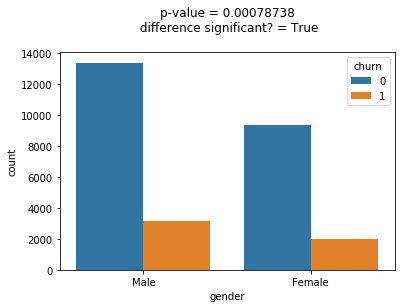

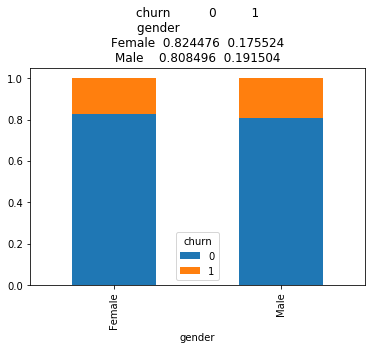

In [19]:
BVA_categorical_plot(data, 'churn', 'gender')

**Result:**

the difference between the males and females customer churning is significant.

### 2. Are young customers more likely to churn?

In [20]:
# segregating customers into segments
churn = data[['churn','age']][:]
churn['age_group'] = 'str'
churn['age_group'][churn['age']>=80] = 'very old'
churn['age_group'][(churn['age']<80) & (churn['age']>=60)] = 'senior citizen'
churn['age_group'][(churn['age']<60) & (churn['age']>=18)] = 'adult'
churn['age_group'][churn['age']<18] = 'young'

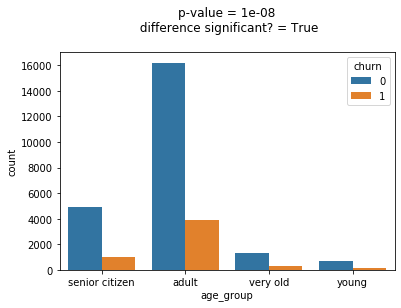

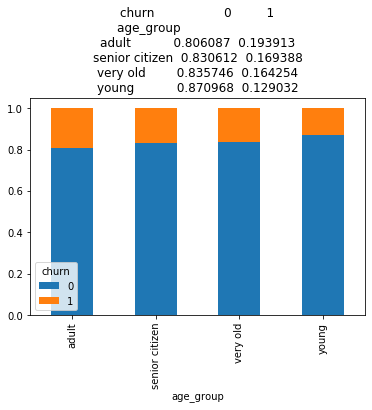

In [21]:
BVA_categorical_plot(churn, 'churn', 'age_group')

**Result**:
Age group has significant effect on the churning rate.

### 3. Customers from low income bracket more likely to churn

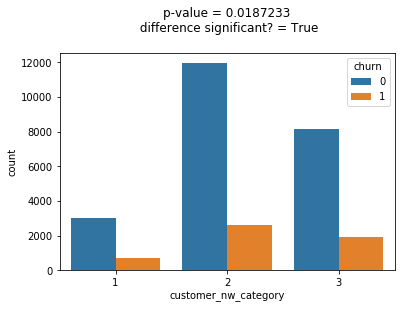

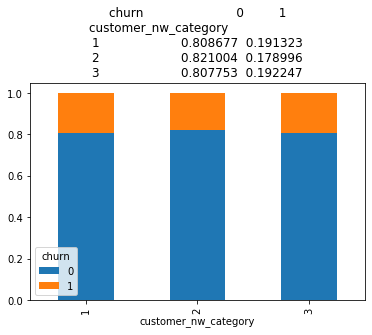

In [22]:
BVA_categorical_plot(data, 'churn', 'customer_nw_category')

**Result:**
Different income brackets have significant effect on the churn rate.

### 4,5. Are customers with dependent(s) less likely to churn?

In [23]:
# segregating dependents into categories
dependents = data[['churn','dependents']][:]
dependents.dropna()
dependents['dep_group'] = None
dependents['dep_group'][dependents['dependents']==0] = 'single'
dependents['dep_group'][(dependents['dependents']>=1) & (dependents['dependents']<=3)] = 'small family'
dependents['dep_group'][(dependents['dependents']>=4) & (dependents['dependents']<=9)] = 'large family'
dependents['dep_group'][(dependents['dependents']>=10)] = 'joint family'

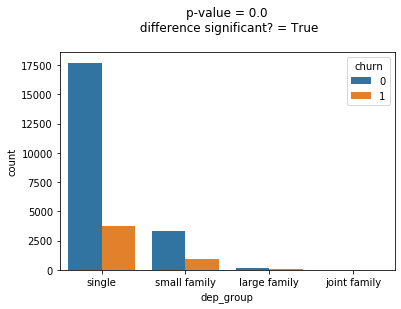

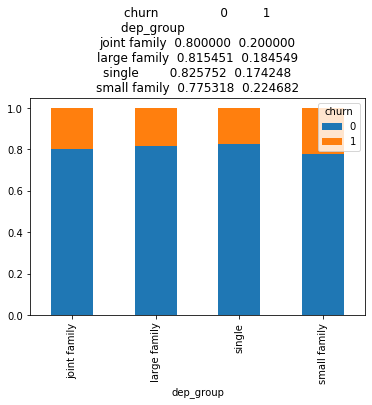

In [24]:
BVA_categorical_plot(dependents, 'churn', 'dep_group')

**Result:**

Number of dependents also play significant role in churning.

### 6. Customers whose last transaction was more than 6 months ago, they have a higher churn rate?

In [27]:
# segregating customers whose last transaction was more than 6 onths ago

transaction = data[['churn','moy_ls_tran']]
transaction['moy_ls_tran'] = transaction['moy_ls_tran'].map(lambda x: 'more than 6 months ago' if x<7 else 'within 6 months')

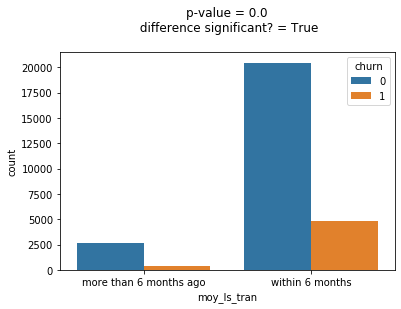

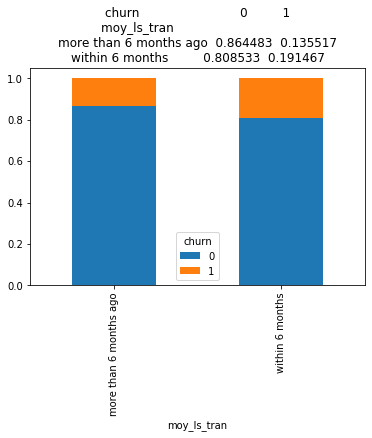

In [28]:
BVA_categorical_plot(transaction, 'churn', 'moy_ls_tran')

**Result**

there is a significant difference between the people who made their last transaction in last 6 months and the customers who had their last transaction more than 6 months ago.

### 7. Possibility that cities and branch code with very few accounts may lead to churning.

#### City

In [29]:
# getting city codes which have less than 280 (1%) of accounts
tmp = data['city'].value_counts()[:]
cities = tmp[tmp<280].index

In [30]:
churn_acc = data[['churn','city']][:]
churn_acc['city_cat'] = None
churn_acc['city_cat'][churn_acc['city'].isin(cities[:])] = 'low accounts'
churn_acc['city_cat'][~churn_acc['city'].isin(cities[:])] = 'high accounts'

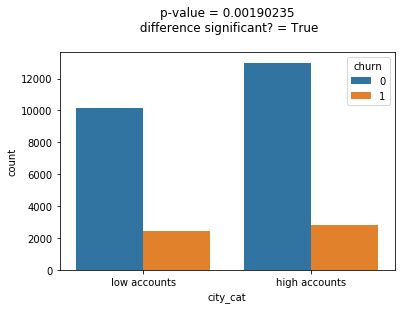

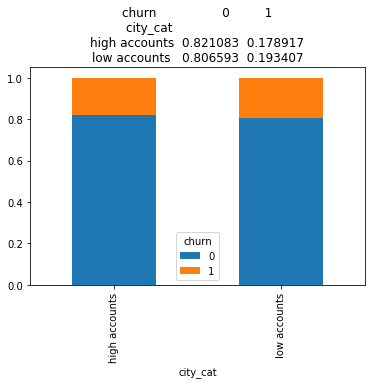

In [31]:
BVA_categorical_plot(churn_acc, 'churn', 'city_cat')

**Result**

cities having less than 1 percent of the total have significantly different churn rates as compared to the cities with more accounts.

#### branch_code

In [32]:
# getting branch codes with more than 0.5% of total accounts
tmp = data['branch_code'].value_counts()[:]
branch = tmp[tmp<140].index

In [33]:
# making two segments
churn_acc = data[['churn','branch_code']][:]
churn_acc['branch_cat'] = None
churn_acc['branch_cat'][churn_acc['branch_code'].isin(branch[:])] = 'low accounts'
churn_acc['branch_cat'][~churn_acc['branch_code'].isin(branch[:])] = 'high accounts'

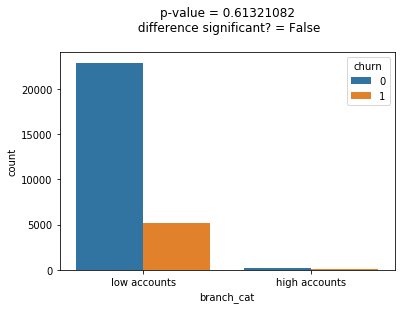

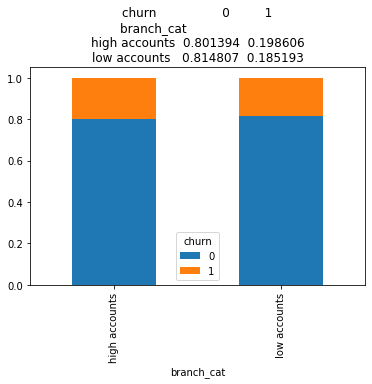

In [34]:
BVA_categorical_plot(churn_acc, 'churn', 'branch_cat')

**Resilt:**

There is no significant difference between the high account count branches and low account count branches.

### Missing Values: Gender

In [37]:
# isolating rows with missing gender
miss_gender = data[:]
miss_gender['missing_gender'] = 'not_missing'
miss_gender['missing_gender'][~miss_gender['gender'].isin(['Male','Female'])] = 'missing value'

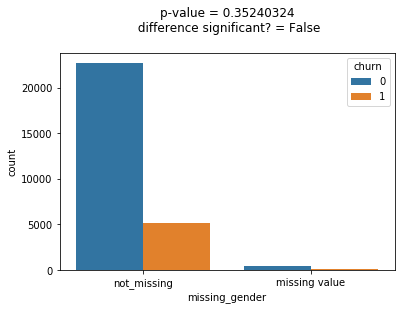

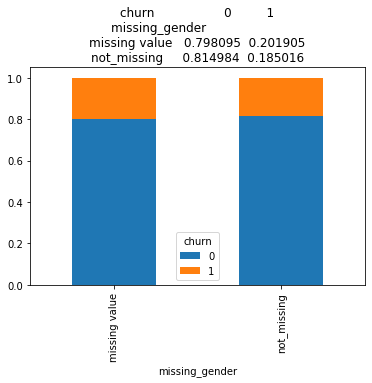

In [38]:
BVA_categorical_plot(miss_gender, 'churn', 'missing_gender')

**There is no diffrent behaviour of the missing values in gender wrt target**


### Missing values : Depedents

In [39]:
# isolating rows with missing gender
miss_dependents = data[:]
miss_dependents['missing_dependents'] = 'not_missing'
miss_dependents['missing_dependents'][~miss_dependents['dependents'].isin([0, 2, 3, 1, 7, 4,
                                                                           6, 5, 9, 52, 36, 50,
                                                                           8, 25, 32])] = 'missing value'

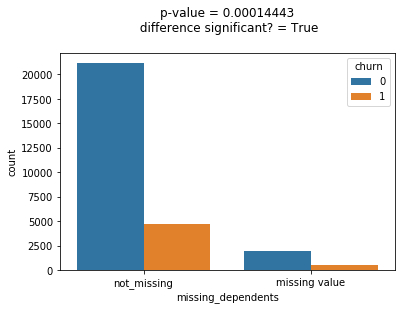

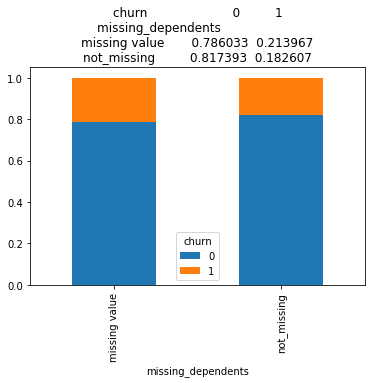

In [40]:
BVA_categorical_plot(miss_dependents, 'churn', 'missing_dependents')

Missing values in dependents have significantly different churning rate than the rest of the data.

### Missing values : Occupation

In [41]:
# isolating rows with missing gender
miss_occupation = data[:]
miss_occupation['missing_occupation'] = 'not_missing'
miss_occupation['missing_occupation'][~miss_occupation['occupation'].isin(['self_employed',
                                                                           'salaried',
                                                                           'retired',
                                                                           'student',
                                                                           'company'])] = 'missing value'

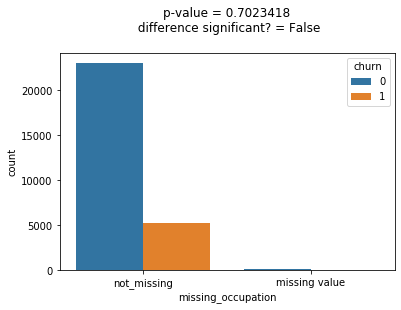

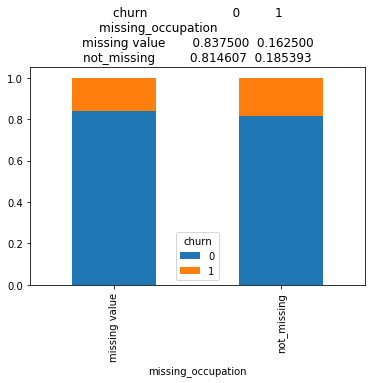

In [42]:
BVA_categorical_plot(miss_occupation, 'churn', 'missing_occupation')

**Missing values in occupation does not have any significantly different relation with churn rate.**